# Lab 7: Non-linear modeling

In [1]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

from pygam import (s as s_gam,
l as l_gam,
f as f_gam,
LinearGAM,
LogisticGAM)

from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
degrees_of_freedom,
plot as plot_gam,
anova as anova_gam)


## 7.8.1 Polynomial Regression and Step Functions

In [2]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

# create a matrix that will fit a 4th degree polynomial in age
poly_age = MS([poly('age', degree=4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [3]:
# create a grid of values for age at which we want predictions
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})

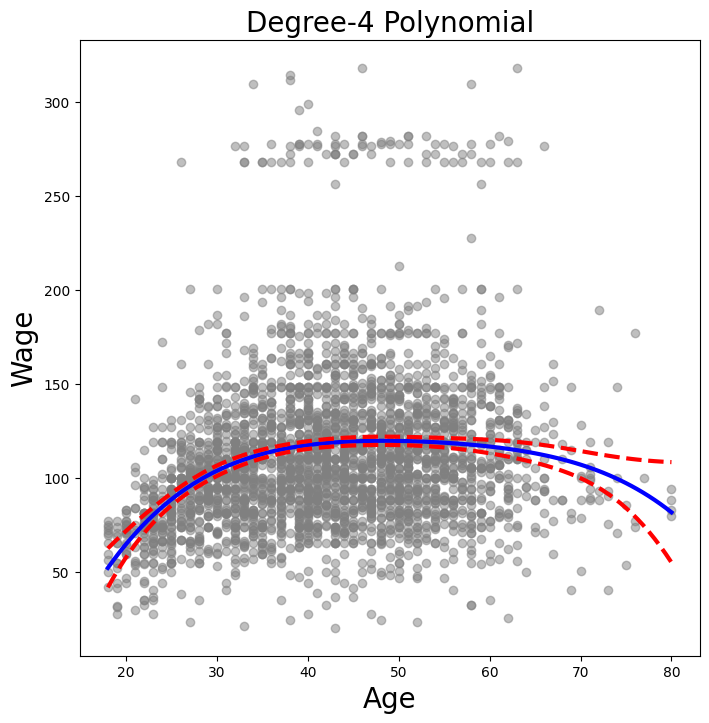

In [4]:
# plot the data and the fit from the 4th-degree polynomial
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age, y, facecolor='gray', alpha=0.5)
    for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]], ['b', 'r--', 'r--'] ):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20)
    return ax

plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial');

How to choose degree of polynomials
1. fit a series of models raning from linear (degree-one) to degree-give polynomials
2. look to determine the simplest model that is sufficient to explain the relationship between wage and age

ANOVA: analysis of variance

Alternatives: cross-validation

In [5]:
models = [MS([poly('age', degree=d)]) for d in range(1,6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


instead of using anova() function, we could have obtained these p-values more succinctly by exploiting the fact that poly() creates orthogonal polynomials.

But ANOVA works in general, whether we use orthogonal polynomials or not.

In [6]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


 p-values are the same for summarize() as well as anova().

 the squares of the t-statistics are equal to the F-statistic from the anova_lm() function

In [7]:
(-11.938) **2

142.51584400000002

In [8]:
models = [MS(['education', poly('age', degree=d)]) for d in range(1,4)]

XEs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


Predict whether an individual earns more than $250,000 per year

In [9]:
X = poly_age.transform(Wage)
from ISLP.models import summarize
high_earn = Wage['high_earn'] = y > 250
glm = sm.GLM(y > 250,\
            X, 
            family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


In [10]:
# make predictions
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

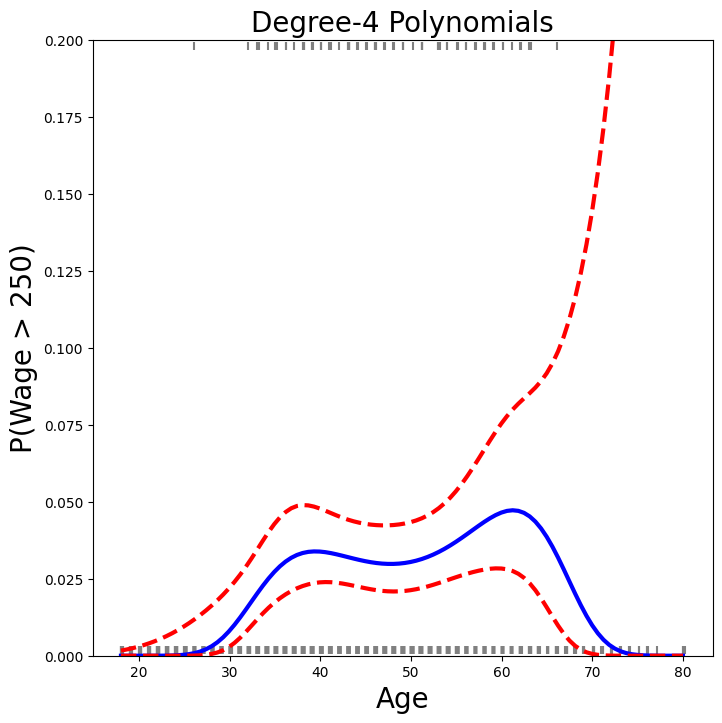

In [11]:
# plot the relationship
fig, ax = subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age + \
            0.2 * rng.uniform(size=y.shape[0]),\
            np.where(high_earn, 0.198, 0.002),
            fc='gray',
            marker='|')

for val, ls, in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]],\
                    ['b', 'r--', 'r--']):
    ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree-4 Polynomials', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('P(Wage > 250)', fontsize=20)
ax.set_ylim([0, 0.2]);


## step function
1. use pd.qcut() function to discretize age based on quantiles
2. use pd.get_dummies() to create the columns of the model matrix for this categorical variable. **This function will include all columns for a given categorical, rather than droping one of the levels**.

note:
* since age is the only variable in the model, the value $94,158.40 is the average salary for those under 33.75 years of age, and the other coefficients are the **average salary** for those in the other age groups.

In [12]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


## 7.8.2 Splines

In [13]:
# The BSpline() function generates the entire matrix of basis functions for splines with the specified set of knots.
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [14]:
# fit a cubic spline model to the Wage data.
bs_age = MS([bs('age', internal_knots=[25,40,60])])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is because, by
default, bs() assumes intercept=False, since we typically have an overall
intercept in the model. So it generates the spline basis with the given knots,
and then discards one of the basis functions to account for the intercept.

In [15]:
#truncate name
bs_age = MS([bs('age', internal_knots=[25,40,60],name='bs(age)')])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


In [16]:
Xbs

,intercept,bs(age)[0],bs(age)[1],bs(age)[2],bs(age)[3],bs(age)[4],bs(age)[5]
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,1.0,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0
...,...,...,...,...,...,...,...
2995,1.0,0.000000,0.139320,0.628472,0.230208,0.002000,0.0
2996,1.0,0.137741,0.629111,0.228819,0.004329,0.000000,0.0
2997,1.0,0.302617,0.586851,0.110255,0.000277,0.000000,0.0
2998,1.0,0.302617,0.586851,0.110255,0.000277,0.000000,0.0


We could also use the df (degrees of freedom) option to specify the complexity
of the spline. We see above that with 3 knots, the spline basis has
6 columns or degrees of freedom. When we specify df=6 rather than the
actual knots, bs() will produce a spline with 3 knots chosen at uniform
quantiles of the training data. We can see these chosen knots most easily
using Bspline() directly:

In [17]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

When asking for six degrees of freedom, the transform chooses knots at
ages 33.75, 42.0, and 51.0, which correspond to the 25th, 50th, and 75th
percentiles of age.

When using B-splines we need not limit ourselves to cubic polynomials
(i.e. degree=3). For instance, using degree=0 results in piecewise constant
functions, as in our example with pd.qcut() above.

In [18]:
bs_age0 = MS([bs('age', df=3, degree=0)]).fit(Wage)
Xbs0 = bs_age0.transform(Wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


In [19]:
# Natural splines with 5 degree of freedom (excluding the intercept)
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


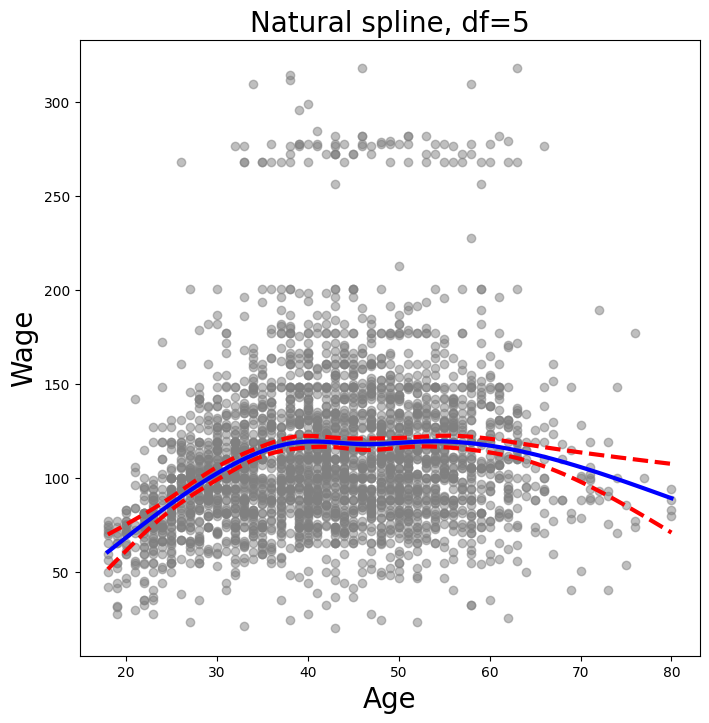

In [20]:
# plot natural spline
plot_wage_fit(age_df, ns_age, 'Natural spline, df=5');

## 7.8.3 Smoothing Splines and GAMs
A smoothing spline is a special case of a GAM with a squared-error loss and a single feature.
The GAM is specified by associating each column of a model matrix with a particular smoothing operation: 
* s for smoothing spline
* l for linear
* f for factor or categorical variables.

In [21]:
X_age = np.asarray(age).reshape((-1,1))

# argument 0 indicates the column 0 of the model matrix
# argument lam indicates parameter lambda
gam = LinearGAM(s_gam(0, lam=0.6))

gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

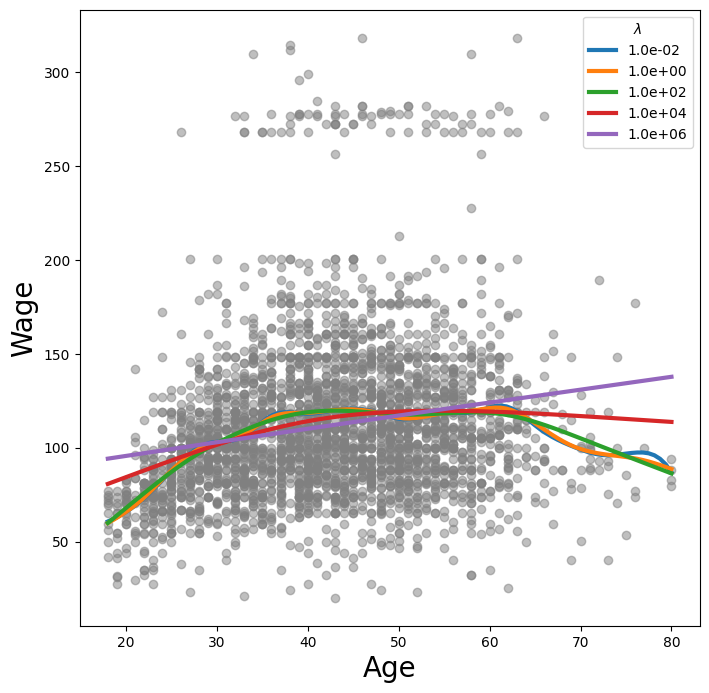

In [22]:
# plot different smoothing splines with different lambdas
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for lam in np.logspace(-2, 6, 5): # vary lam from 10^-2 to 10^6
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid, gam.predict(age_grid), label='{:.1e}'.format(lam), linewidth=3)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title=r'$\lambda$');


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


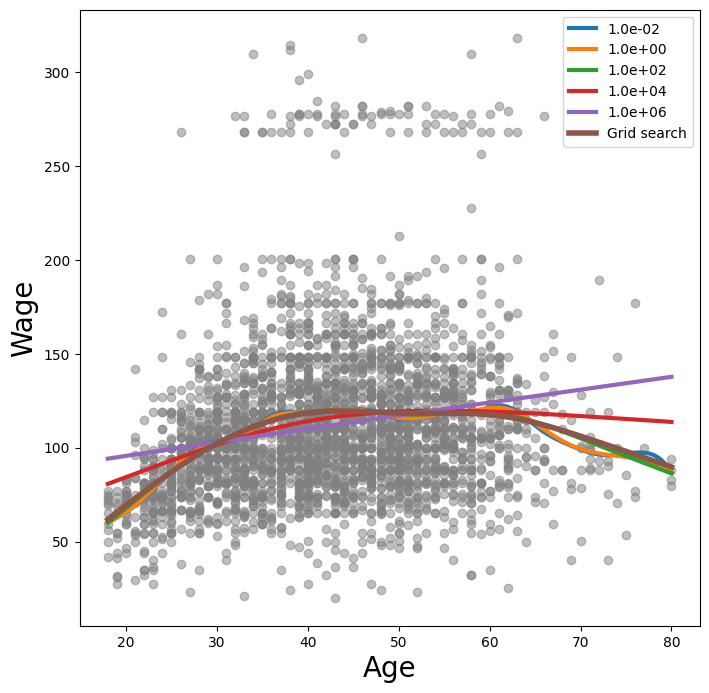

In [23]:
# search for an optimal smoothing paramter
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid, \
        gam_opt.predict(age_grid), 
        label='Grid search',
        linewidth=4)
ax.legend()
fig

In [24]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100001664

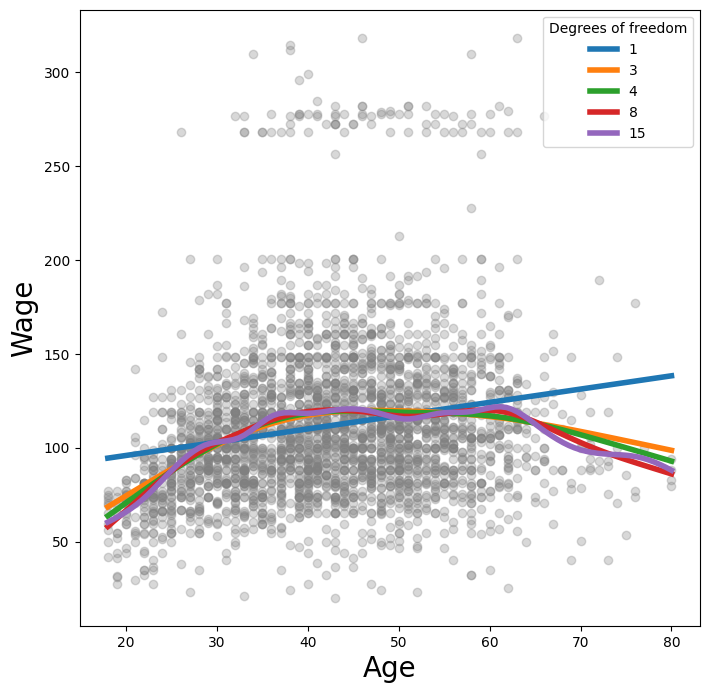

In [25]:
# vary degrees of freedom
fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age, y, facecolor='gray', alpha=0.3)
for df in [1, 3, 4, 8, 15]:
    lam = approx_lam(X_age, age_term, df+1) # df+1 to account for the intercept term
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid, \
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='Degrees of freedom');

### Additive models with several terms
Method 1 - Manual: using natural splines and piecewise constant functions

In [26]:
# buid model matrix
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),\
    ns_year.transform(Wage['year']),
    pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()

construct partial dependence plots for each of the terms in our rudimentary GAM: predict with new *X* matrices, fixing all but one of the features at a time

Idea: to create a new prediction matrix, where all but the columns belonging to $age$ are constant (and set to their training-data means). The four columns for $age$ are filled in with the natural spline basis evaluated at the 100 values in the *age_grid*.
1. Make a grid of length 100 in *age*, and creatd a matrix *X_age_bh* with 100 rows and the same number of columns as X_bh
2. replace every row of this matrix with the column means of the original
3. Replace just the first four columns representing age with the ntural spline basis computed at the values in age_grid.

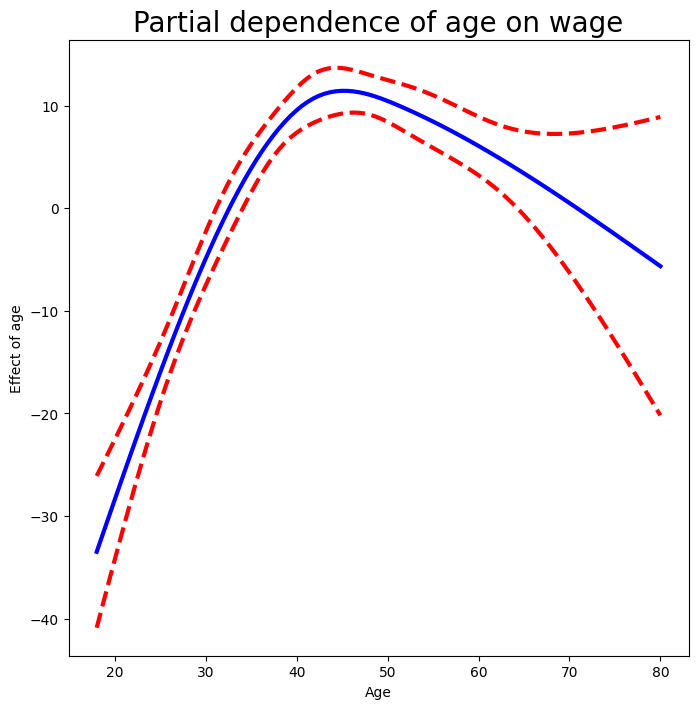

In [27]:
age_grid = np.linspace(age.min(),\
                        age.max(),
                        100)
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None, :]
X_age_bh[:, :4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha=0.05)
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center

fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:, 0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:, 1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect of age')
ax.set_title('Partial dependence of age on wage', fontsize=20);

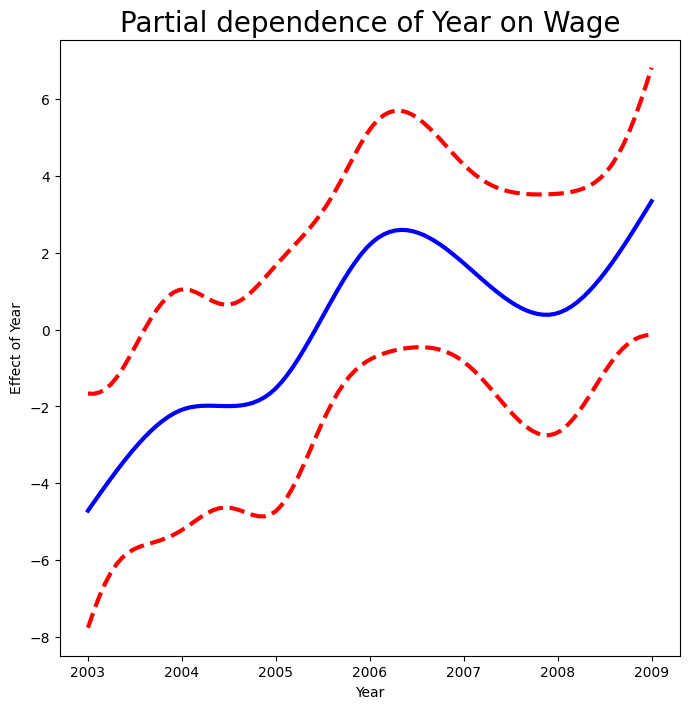

In [28]:
# following the same process, look at the effect of year on wage

year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(), Wage['year'].max(), 100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None, :]
X_year_bh[:, 4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center

# plot the partial effects
fig, ax = subplots(figsize=(8, 8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:, 0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:, 1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect of Year')
ax.set_title('Partial dependence of Year on Wage', fontsize=20);

In [41]:
# fit model (7.16) using smoothing splines
# first 2 s_gam() uses default lambda=0.6
#  f_gam() set lambda=0 to avoid shrinkage
gam_full = LinearGAM(s_gam(0) + \
                    s_gam(1, n_splines=7) + \
                    f_gam(2, lam=0))
Xgam = np.column_stack([age,\
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

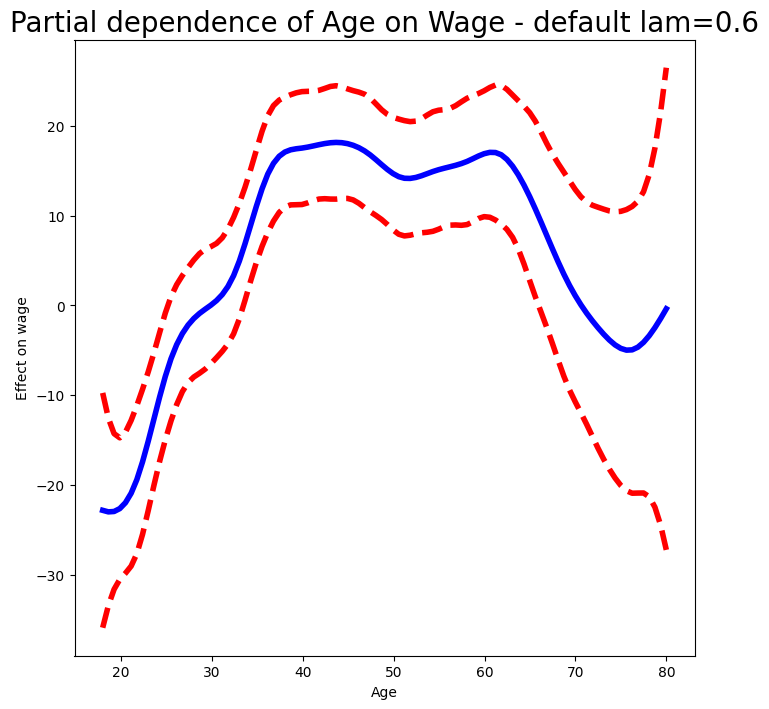

In [42]:
# use plot_gam() function instead of manually plotting in the previous examples
fig, ax = subplots(figsize=(8, 8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of Age on Wage - default lam=0.6', fontsize=20);

In [43]:
# refit a GAM using four degrees of freedom each for age and year
age_term = gam_full.terms[0]
# udpate age_term.lam has the effect of updating it in in gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)

year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

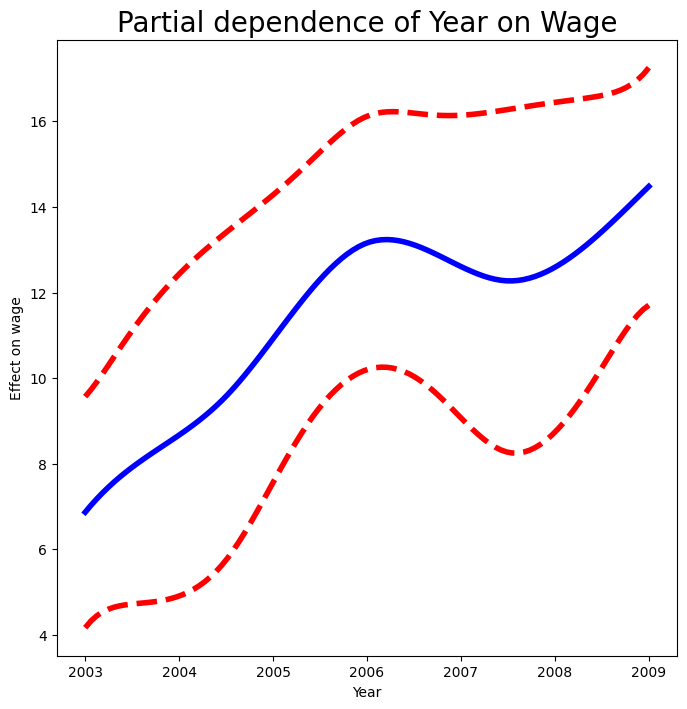

In [44]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,\
        1,
        ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of Year on Wage', fontsize=20);

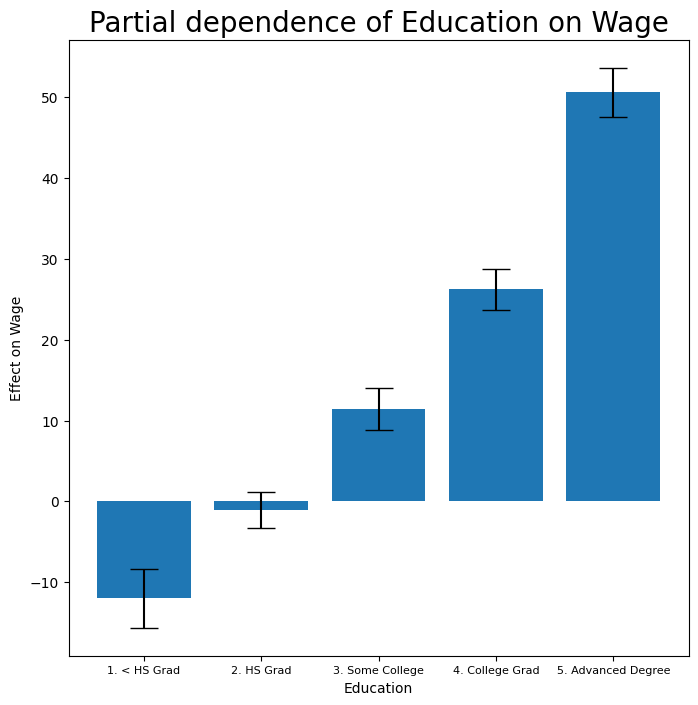

In [46]:
# plot education

fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial dependence of Education on Wage', fontsize=20)
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);

### ANOVA Tests for Additive Models

* model 1: GAM that excludes *year*
* model 2: GAM uses linear function of *year*
* model 3: GAM uses spline functin of *year*

In [51]:
gam_0 = LinearGAM(age_term + f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear = LinearGAM(age_term + \
                        l_gam(1, lam=0) + \
                        f_gam(2, lam=0))
gam_linear.fit(Xgam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

We find that there is compelling evidence that a GAM with a linear function
in year is better than a GAM that does not include year at all (p-value=
0.002). However, there is no evidence that a non-linear function of year
is needed (p-value=0.435). In other words, based on the results of this
ANOVA, M2 is preferred.

In [52]:
# access effect of year, run ANOVA on 3 models fit above
anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [ ]:
# repeat ANOVA for age
gam_0 = LinearGAM(year_term + \
                f_gam(2, lam=0))
gam_linear = LinearGAM(l_gam(0, lam=0) + \
                        year_term + \
                        f_gam(2, lam=0))
gam_0.fit(Xgam, y)
gam_linear.fit(Xgam, y)

anova_gam(gam_0, gam_linear, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.975443e+06,2991.000589,NaN,NaN,NaN,NaN
1,3.850247e+06,2990.000704,125196.137317,0.999884,101.270106,1.681120e-07
2,3.693143e+06,2987.007254,157103.978302,2.993450,42.447812,5.669414e-07


In [55]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_33447/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


We can make predictions from gam objects, just like from lm objects, using
the predict() method for the class gam. Here we make predictions on the
training set.

In [56]:
Yhat = gam_full.predict(Xgam)

In order to fit a logistic regression GAM, we use LogisticGAM() from LogisticGAM() pygam.

In [57]:
gam_logit = LogisticGAM(age_term + \
                        l_gam(1, lam=0) + \
                        f_gam(2, lam=0))
gam_logit.fit(Xgam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + l(1) + f(2) + intercept, tol=0.0001, verbose=False)

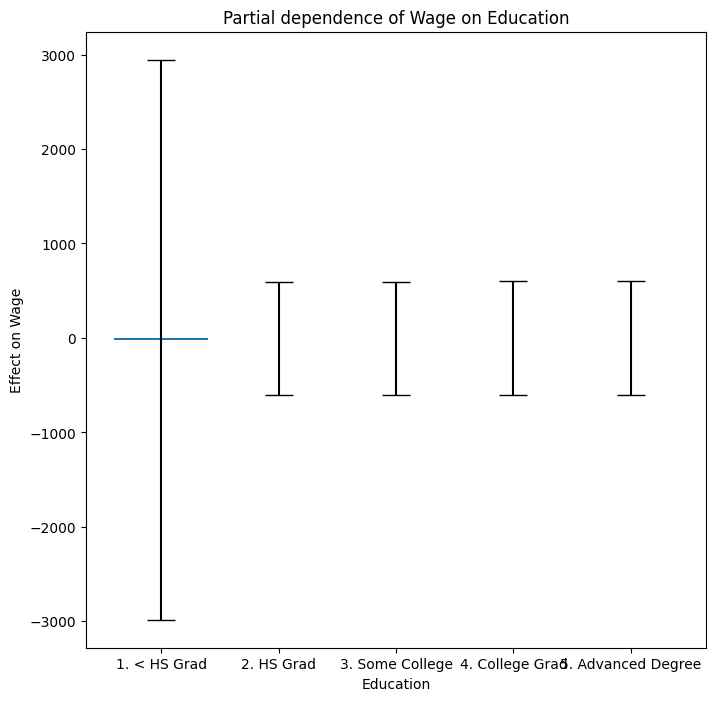

In [59]:
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial dependence of Wage on Education')
ax.set_xticklabels(Wage['education'].cat.categories);

In [60]:
pd.crosstab(Wage['high_earn'], Wage['education'])

education,1. < HS Grad,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree
high_earn,,,,,
False,268,966,643,663,381
True,0,5,7,22,45


We see that there are no high earners in the first category of education,
meaning that the model will have a hard time fitting. We will fit a logistic
regression GAM excluding all observations falling into this category. This
provides more sensible results.

To do so, we could subset the model matrix, though this will not remove
the column from Xgam. While we can deduce which column corresponds to
this feature, for reproducibility’s sake we reform the model matrix on this
smaller subset.

In [61]:
only_hs = Wage['education'] == '1. < HS Grad'
Wage_ = Wage.loc[~only_hs]
Xgam_ = np.column_stack([Wage_['age'], \
                        Wage_['year'], \
                        Wage_['education'].cat.codes-1])
high_earn_ = Wage_['high_earn']

In the second-to-last line above, we subtract one from the codes of the
category, due to a bug in pygam. It just relabels the education values and
hence has no effect on the fit.

In [63]:
# fit the model
gam_logit_ = LogisticGAM(age_term + \
                        year_term + \
                        f_gam(2, lam=0))
gam_logit_.fit(Xgam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

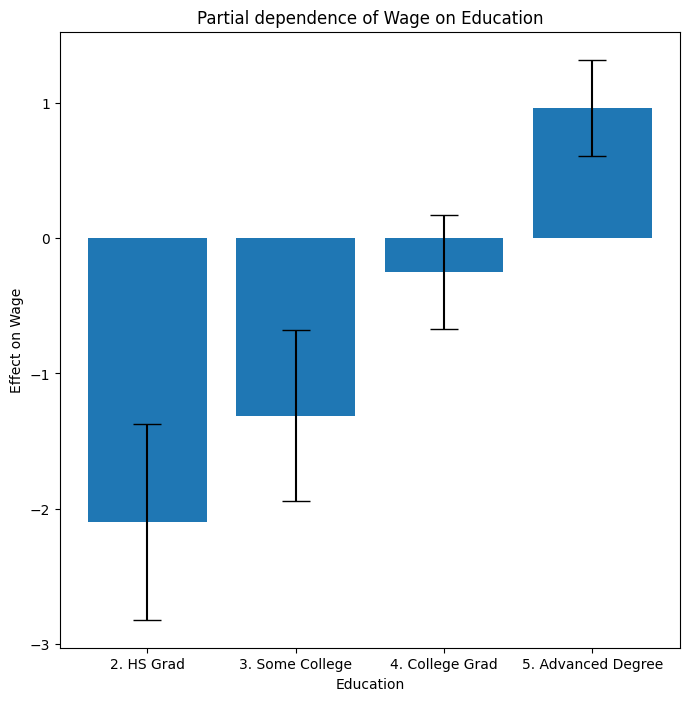

In [ ]:
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit_, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial dependence of highe earner status on Education')
ax.set_xticklabels(Wage['education'].cat.categories[1:]);

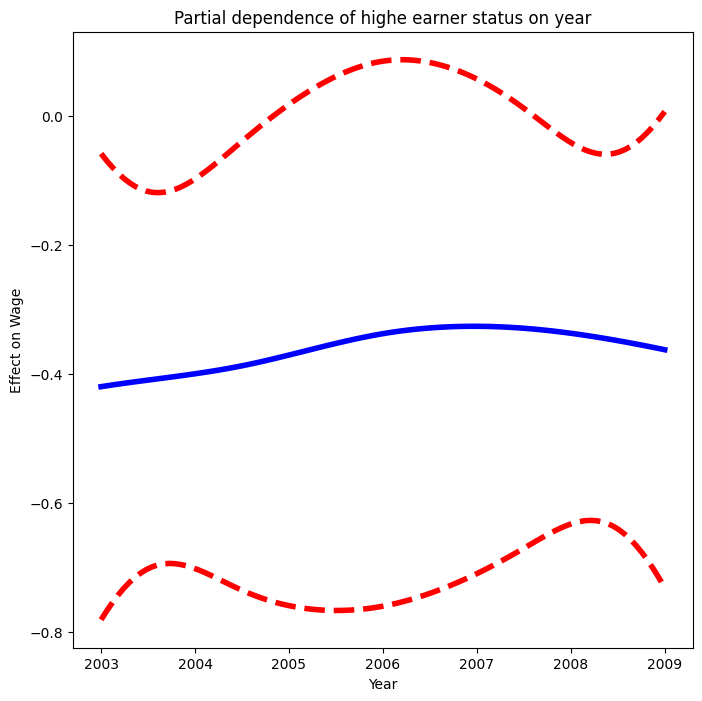

In [69]:
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit_, 1)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial dependence of highe earner status on year');

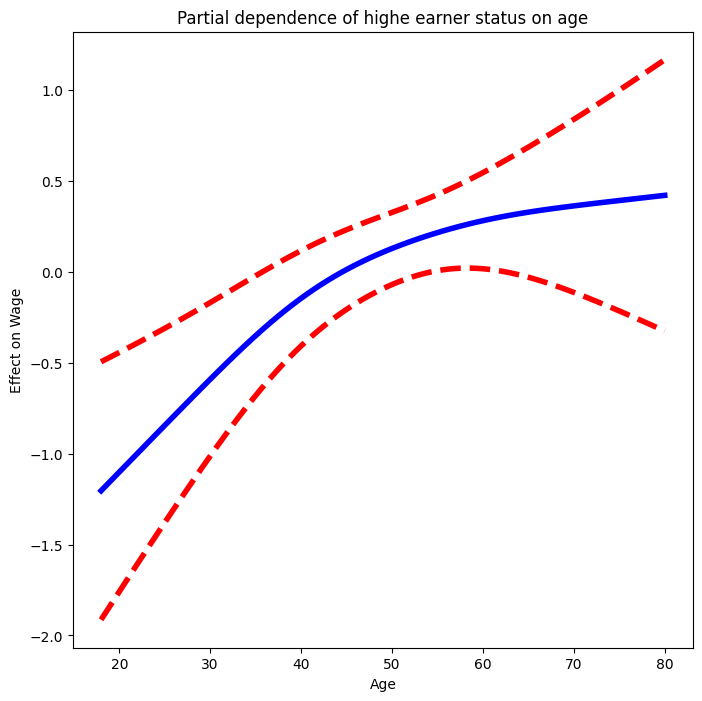

In [70]:
fig, ax = subplots(figsize=(8,8))
ax = plot_gam(gam_logit_, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on Wage')
ax.set_title('Partial dependence of highe earner status on age');

## 7.8.4 Local regression
We illustrate the use of local regression using the lowess() function from lowess() sm.nonparametric. Some implementations of GAMs allow terms to be local
regression operators; this is not the case in pygam.

Here we fit local linear regression models using spans of 0.2 and 0.5;
that is, each neighborhood consists of 20% or 50% of the observations. As
expected, using a span of 0.5 is smoother than 0.2.

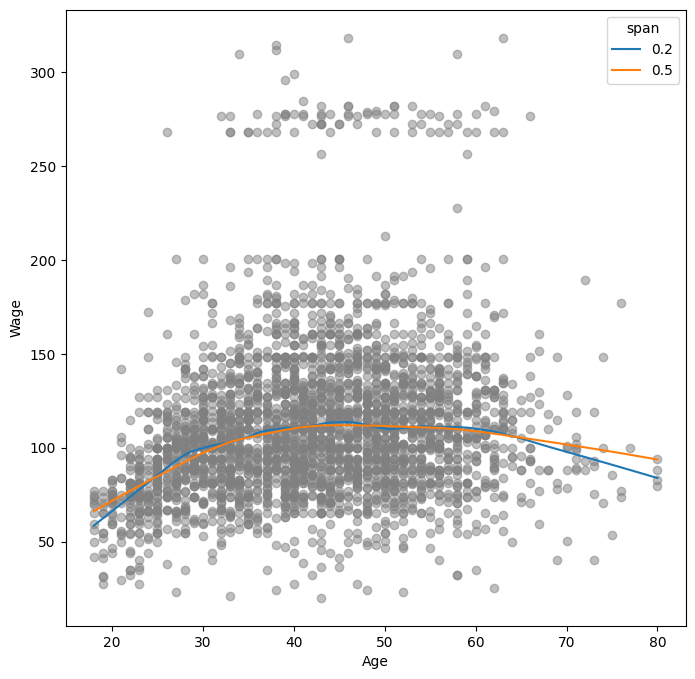

In [74]:
lowess = sm.nonparametric.lowess
fig, ax = subplots(figsize=(8,8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
for span in [0.2, 0.5]:
    fitted = lowess(y, age, frac=span, xvals=age_grid)
    ax.plot(age_grid, fitted, label='{:.1f}'.format(span))
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.legend(title='span');